In [1]:
%matplotlib inline
import pandas as pd
import pickle
import plotly.express as px
from tqdm import tqdm
import csv

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 400)
pd.set_option("display.max_colwidth", None) # None for all of it
PARTYCOLORS =  {'AfD': '#59dcff', "CSU":"#525060", "CDU":"black", "CDU/CSU":"black","SPD":"#e03427", "GRUENE":"#52d157", "DIE LINKE":"#a33ab5", "FDP":"#ffeb3b",}

In [2]:
# Imports for BERTopic

from bertopic.representation import MaximalMarginalRelevance
from umap import UMAP
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic

In [3]:
# Import selected sentences and select electoral period 19
stc = pd.read_feather("data/sentences_climate.feather")
stc = stc[stc["electoral_term"]==19]
# Merge CDU/CSU to one
stc.loc[(stc["party"] == "CSU") | (stc["party"] == "CDU"), "party"] = "CDU/CSU" 
stc = stc.reset_index()
stc.head(1)

,index,level_0,sent_id,speech_id,name,electoral_term,party,role,date,session,sentence_no,sentence_length,sentence
0,0,655371,945629,37018,Ralph Lenkert,19,DIE LINKE,mp,2018-10-18,58,7,7,Für die Energiewende brauchen wir diese Anlagen.


In [4]:
stc.shape

(10995, 13)

In [5]:
from sentence_transformers import SentenceTransformer

## Prepare embeddings
# Small sentence transformer
# sentence_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
# Large sentence transformer
sentence_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

In [6]:
## Only needs to be done once
#speeches = stc["sentence"].to_list()
#embeddings = sentence_model.encode(speeches)

#with open('mpnet-base-v2_climate_embedding.pickle', 'wb') as pkl:
#    pickle.dump(embeddings, pkl)

In [7]:
# Load embeddings from pickle
speeches = stc["sentence"].to_list()
with open('mpnet-base-v2_climate_embedding.pickle', 'rb') as pkl:
    embeddings = pickle.load(pkl)
len(speeches)

10995

In [8]:
# Count documents of each party in each topic
def count_topic_by_party(dftm):
    dfcount = pd.DataFrame(dftm.groupby(["party", "Topic"])["Document"].count()).reset_index()
    missing_count = []
    
    for party in dftm.party.unique().tolist():
        for i in range(max(topic_model.topic_sizes_.keys())+1):
            if len(dfcount[(dfcount["party"] == party) & (dfcount["Topic"] == i)]) == 0:
                missing_count.append([party, i, 0])
    
    missingdf = pd.DataFrame(missing_count, columns=['party','Topic','Document'])
    dfcount = pd.concat([dfcount, missingdf]).reset_index()
    return dfcount

In [9]:
def fit_model(params):
    umap_model = UMAP(n_neighbors=params["umap_n_neigh"], n_components=params["umap_n_comp"], metric='cosine', random_state=params["random_state"], low_memory=False)
    
    # Create representation model
    representation_model = MaximalMarginalRelevance(diversity=0.15, top_n_words=15)
    
    # Vectorizer to remove german stop words from representation
    german_stop_words = stopwords.words('german')
    vectorizer_model = CountVectorizer(stop_words = german_stop_words)
    
    topic_model = BERTopic(representation_model=representation_model, vectorizer_model=vectorizer_model, umap_model=umap_model, 
                           embedding_model=sentence_model, top_n_words=12, min_topic_size=params["min_topic_size"])

    topics, probs = topic_model.fit_transform(speeches, embeddings)
    
    return topic_model, topics, probs

In [10]:
def results_summary(stc, speeches, topics, outlier_reduced=False):
    # Results as dataframe
    dftm = pd.DataFrame({"Document": speeches, "Topic": topics})
    dftm = dftm.join(stc.party).join(stc.session).join(stc.speech_id).join(stc.sent_id)
    #dftm.sample()
    
    dfcount = count_topic_by_party(dftm)
    
    dfcount["total"] = dftm.party.value_counts()[dfcount["party"]].reset_index()["count"]
    dfcount["topic_salience"] = dfcount["Document"] / dfcount["total"]
    dfcount["salience_sum"] = dfcount.Topic.map(dfcount.groupby("Topic").topic_salience.sum())
    dfcount["salience_normalized"] = dfcount["topic_salience"] / dfcount["salience_sum"]
    dfcount["std_sal_normalized"] = dfcount.Topic.map(dfcount.groupby("Topic")["salience_normalized"].std())
    dfcount.loc[:,"mean_normalized"] = dfcount.Topic.map(dfcount.groupby("Topic").salience_normalized.mean())
    dfcount.loc[:,"sal_diff"] = abs(dfcount["salience_normalized"] - dfcount["mean_normalized"])
    
    #percentage of outliers
    percentage_outlier = dfcount[dfcount["Topic"] == -1]["Document"].sum()/len(speeches)
    
    # Mean std deviation of normalized topic salience 
    import statistics
    sal_std = statistics.mean(dfcount[(dfcount["Topic"]>-1)].groupby("Topic")["salience_normalized"].std())

    params["num_topics"] = dftm.Topic.nunique()
    params["perc_outlier"] = f"{(percentage_outlier):.4f}"
    params["max_topic_count"] = dftm[dftm["Topic"]>-1].Topic.value_counts().max()
    params["sal_std"] = f"{(sal_std):.4f}"
    params["top_sal_diff"] = dfcount.sort_values("sal_diff").tail(20).sal_diff.mean()
    params["high_sal_diff_perc_of_topic"] = f"{(dfcount[dfcount["sal_diff"] > 0.2].party.value_counts().sum() / params["num_topics"]):.4f}"
    params["perc_top_party_high_sal_diff"] = dfcount.sort_values("sal_diff").tail(20).party.value_counts().max()
    params["outlier_reduced"] = outlier_reduced
    
    ## Only needed for hyperparameter tuning
    #with open("bertopic_params.csv", "a", newline="") as f:
    #    w = csv.DictWriter(f, params.keys())
    #    w.writerow(params)

    return dftm, dfcount

In [ ]:
# Hyperparameter tuning
for n in tqdm([5,6,7]):
    for rs in [2,18,42,41,43,45,99]:
        params = {"umap_n_neigh":n, "umap_n_comp": 5, "min_topic_size":15, "random_state": rs}
        # Do the modelling
        topic_model, topics, probs = fit_model(params)
        results_summary(stc, speeches, topics)
        
        #reducing outliers
        try:
            tps = topic_model.reduce_outliers(speeches, topics , strategy="embeddings", embeddings=embeddings, threshold=0.75)
            dftm, dfcount = results_summary(stc, speeches, tps, outlier_reduced=True)
        except:
            pass

In [ ]:
# Evaluation of parameter tuning
hp = pd.read_csv("bertopic_params.csv", header=None)
hp = hp[hp[4] > 70]
hp = hp.set_axis(params.keys(), axis=1)
#hp.mean()
hp = hp[hp["outlier_reduced"]]
hp

In [11]:
params = {"umap_n_neigh":6, "umap_n_comp": 5, "min_topic_size":15, "random_state": 2}

# Do the modelling
topic_model, topics, probs = fit_model(params)
dftm, dfcount = results_summary(stc, speeches, topics)

tps = topic_model.reduce_outliers(speeches, topics , strategy="embeddings", embeddings=embeddings, threshold=0.75)
dftm, dfcount = results_summary(stc, speeches, tps, outlier_reduced=True)

In [ ]:
# Test different settings of outlier reduction
#for perc in [0.85, 0.8, 0.75, 0.7]:
#    #reducing outliers
#    tps = topic_model.reduce_outliers(speeches, topics , strategy="embeddings", embeddings=embeddings, threshold=0.75)
#    dftm, dfcount = results_summary(stc, speeches, tps, outlier_reduced=True)


# testing outlier reduction

In [268]:
# oulier before
dfcount[dfcount["Topic"] == -1]["Document"].sum()/len(speeches)

0.42473851750795816

In [269]:
dftm["outlier"] = False
dftm.loc[dftm["Topic"] == -1, "outlier"] = True
outlier = dftm[["sent_id", "outlier"]]

In [270]:
#reducing outliers
perc = 0.75
tps = topic_model.reduce_outliers(speeches, topics , strategy="embeddings", embeddings=embeddings, threshold=perc)
dftm, dfcount = results_summary(stc, speeches, tps, outlier_reduced=True)
#percentage of outliers after outlier reduction
print(f"Percentage outlier at {perc} threshhold: {(dfcount[dfcount["Topic"] == -1]["Document"].sum()/len(speeches))}")

In [117]:
# merge outlier label to df
dftm = dftm.merge(outlier, on="sent_id")

In [1059]:
# Overview where the outlier got reattributed to
# dftm[dftm["outlier"]].Topic.value_counts()

In [1060]:
#topic_model.get_topic_info(84)

# Overview Topics

In [15]:
dftm[dftm["Topic"]==80].groupby(["Topic", "party"]).count()

Document  session  speech_id  sent_id
Topic party                                         
80    CDU/CSU        24       24         24       24
      FDP             3        3          3        3
      GRUENE          1        1          1        1
      SPD             7        7          7        7

In [13]:
print("Number of sentences:", dfcount.Document.sum())
print("Number of Topics:", dfcount["Topic"].max())
print("Size smallest and biggest Topic:", dftm[dftm["Topic"]>-1].Topic.value_counts().min(), dftm[dftm["Topic"]>-1].Topic.value_counts().max())
print("% outlier", dfcount[dfcount["Topic"] == -1]["Document"].sum()/dfcount["Document"].sum())

Number of sentences: 10995
Number of Topics: 94
Size smallest and biggest Topic: 15 508
% outlier 0.1495225102319236


In [ ]:
# Save all topic representations to table
topic_model.get_topic_info()[["Topic", "Count", "Representation"]].to_csv("overview_topics_bundestag19.csv", index=False)

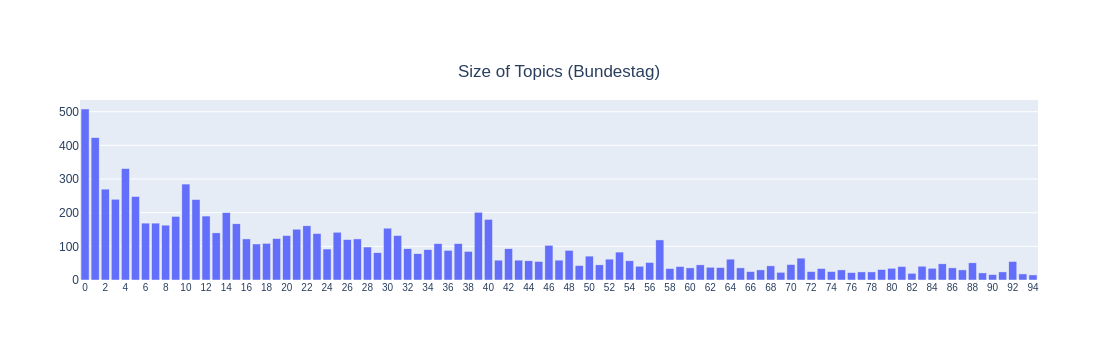

In [27]:
fig = px.bar(dftm[~(dftm["Topic"]==-1)].Topic.value_counts(), title="Size of Topics (Bundestag)")
fig.update_layout(title_x=0.5, title_y=0.82, showlegend=False, xaxis_title=None, yaxis_title=None)
fig.update_layout(xaxis=dict(tickfont_size=10, tickvals=list(range(0, dfcount["Topic"].nunique(), 2))))
#fig.update_traces(textfont_size=14, textangle=0, textposition="outside", cliponaxis=False)
fig.update_xaxes(tickangle=0)
fig.show()

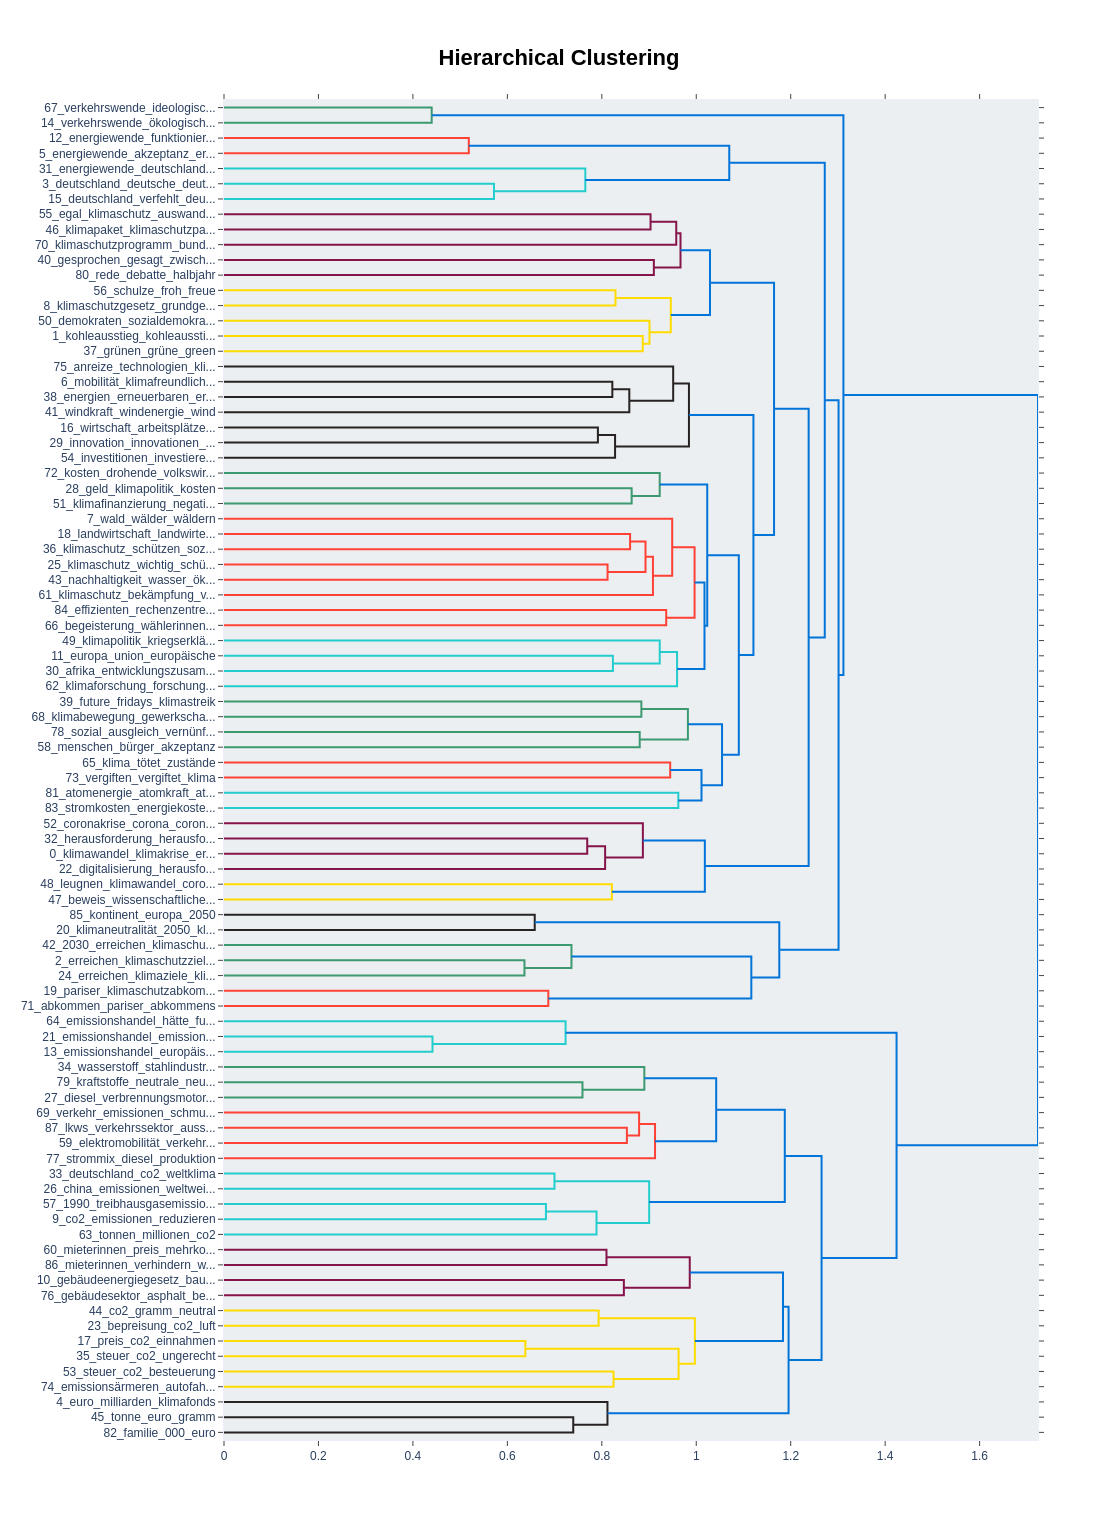

In [121]:
topic_model.visualize_hierarchy()

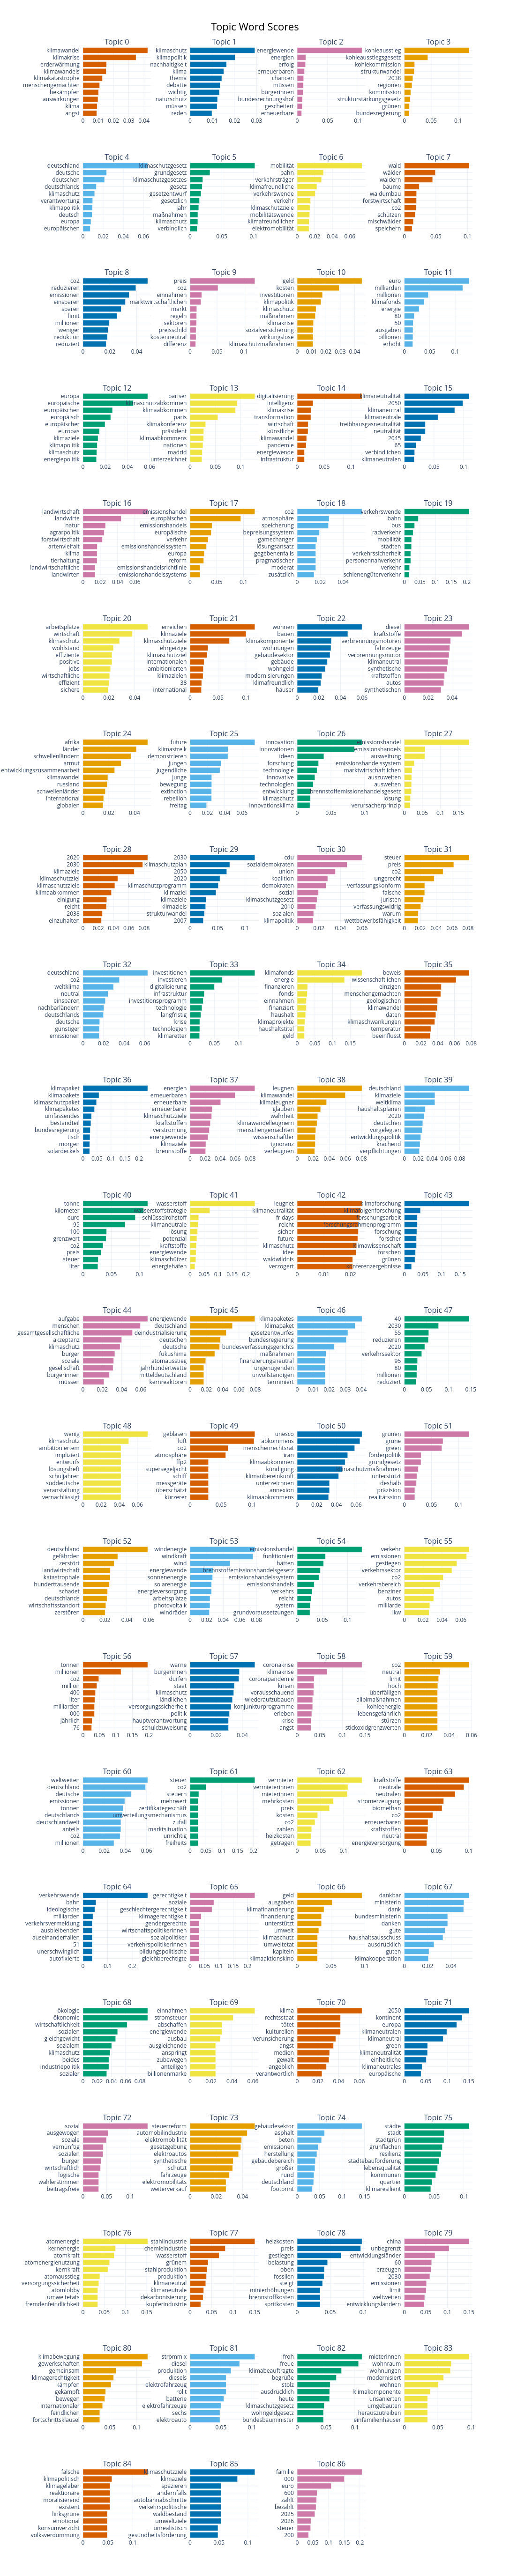

In [971]:
topic_model.visualize_barchart(top_n_topics = 87, n_words = 15)

# Topic salience Party Comparison

In [71]:
dfcount[dfcount["Topic"] == 3]

,index,party,Topic,Document,total,topic_salience,mean_salience_across_party,salience_sum,salience_normalized,std_sal_normalized,mean_normalized,sal_diff
4,4,AfD,3,31,1543,0.020091,0.039873,0.239238,0.083978,0.097897,0.166667,0.082688
76,76,CDU/CSU,3,85,2598,0.032717,0.039873,0.239238,0.136757,0.097897,0.166667,0.029909
152,152,DIE LINKE,3,93,1202,0.077371,0.039873,0.239238,0.323407,0.097897,0.166667,0.156740
227,227,FDP,3,17,1365,0.012454,0.039873,0.239238,0.052058,0.097897,0.166667,0.114609
302,302,GRUENE,3,112,2328,0.048110,0.039873,0.239238,0.201097,0.097897,0.166667,0.034430
377,377,SPD,3,95,1959,0.048494,0.039873,0.239238,0.202703,0.097897,0.166667,0.036036


In [27]:
# Salience not normalized
graphdf1 = dfcount[(dfcount.Topic < 30) & (dfcount["Topic"] > -1) ]
graphdf2 = dfcount[(dfcount.Topic >= 30) & (dfcount.Topic < 60)]
graphdf3 = dfcount[(dfcount.Topic >= 60) ]
#fig = px.bar(graphdf1, x="Topic", y="topic_salience", color="party", barmode='group', color_discrete_map=PARTYCOLORS, title="Topic salience")
#fig.show()
#fig = px.bar(graphdf2, x="Topic", y="topic_salience", color="party", barmode='group', color_discrete_map=PARTYCOLORS, title="Topic salience")
#fig.show()
#fig = px.bar(graphdf3, x="Topic", y="topic_salience", color="party", barmode='group', color_discrete_map=PARTYCOLORS, title="Topic salience")
#fig.show()

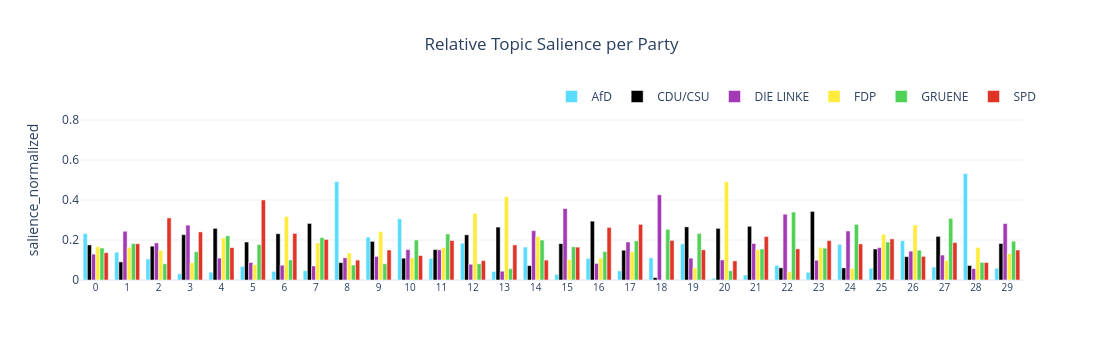

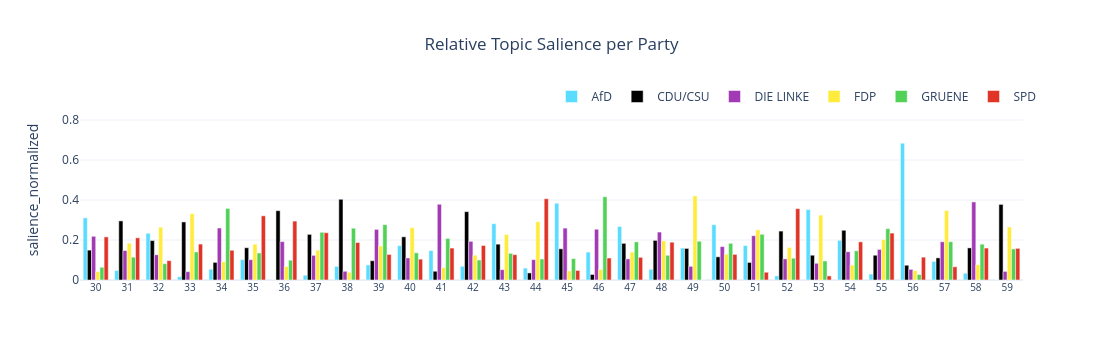

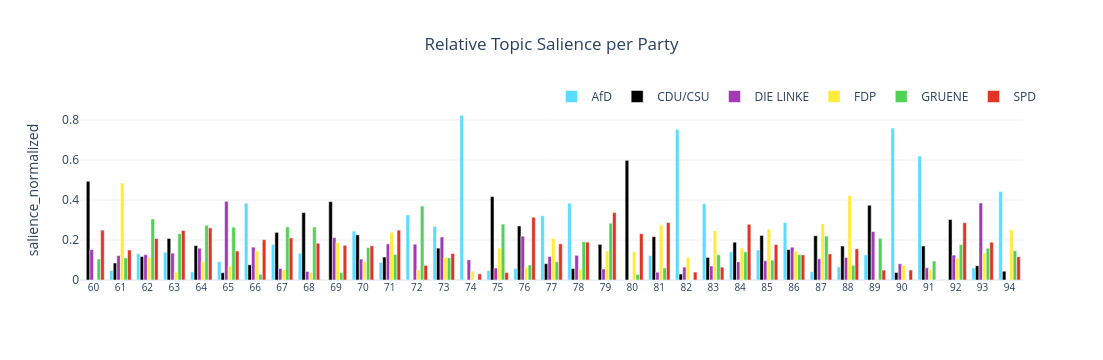

In [30]:
# Salience normalized
fig = px.bar(graphdf1, x="Topic", y="salience_normalized", color="party", range_y=[0,0.9], template="plotly_white", barmode='group', color_discrete_map=PARTYCOLORS, title="Relative Topic Salience per Party").update_layout(title_x=0.5, legend=dict(yanchor="top", y=1.1, xanchor="left", x=0.5, orientation='h', title=""), xaxis_title=None)
fig.update_layout(xaxis=dict(tickfont_size=10, tickvals=list(range(-1, graphdf1["Topic"].nunique()))))
fig.show()
fig = px.bar(graphdf2, x="Topic", y="salience_normalized", color="party", range_y=[0,0.9], template="plotly_white", barmode='group', color_discrete_map=PARTYCOLORS, title="Relative Topic Salience per Party").update_layout(title_x=0.5, legend=dict(yanchor="top", y=1.1, xanchor="left", x=0.5, orientation='h', title=""), xaxis_title=None)

fig.show()
fig = px.bar(graphdf3, x="Topic", y="salience_normalized", color="party", range_y=[0,0.9], template="plotly_white", barmode='group', color_discrete_map=PARTYCOLORS, title="Relative Topic Salience per Party").update_layout(title_x=0.5, legend=dict(yanchor="top", y=1.1, xanchor="left", x=0.5, orientation='h', title=""), xaxis_title=None)
fig.update_layout(xaxis=dict(tickfont_size=10, tickvals=list(range(graphdf3["Topic"].unique().min(), graphdf3["Topic"].unique().max()+1))))
fig.show()

# Detailed Topic inspection

In [17]:
selection_high = dfcount.sort_values("salience_normalized").tail(35)
topicsh = selection_high.Topic.unique()
info = topic_model.get_topic_info()
info = info[info["Topic"].isin(topicsh)]
info = pd.merge(info, selection_high[["Topic","party", "salience_normalized"]])
info.head(1)

,Topic,Count,Name,Representation,Representative_Docs,party,salience_normalized
0,5,170,5_klimaschutzgesetz_grundgesetz_klimaschutzgesetzes_gesetzlich,"[klimaschutzgesetz, grundgesetz, klimaschutzgesetzes, gesetzlich, verabschiedet, gesetz, entwurf, gesetzentwurf, änderung, jahr, klimagesetz, klimaschutzpaket]","[Was steht denn in dem Klimaschutzgesetz?, Damit bin ich beim Klimaschutzgesetz., Wir brauchen auch ein Klimaschutzgesetz.]",SPD,0.400393


In [94]:
info.party.value_counts()

party
AfD          12
CDU/CSU       7
DIE LINKE     6
FDP           5
GRUENE        3
SPD           2
Name: count, dtype: int64

In [113]:
info[info["party"] == "AfD"][["Topic", "Count", "salience_normalized", "Representation", "Representative_Docs"]].sort_values("salience_normalized", ascending=False)

,Topic,Count,salience_normalized,Representation,Representative_Docs
23,74,21,0.824000,"[strommix, diesel, produktion, elektrofahrzeug, fahrleistung, diesels, batterie, ausstoß, elektroauto, moderner, gefahren, co2]","[Denn wenn ein Batterieauto vom Band rollt und noch keinen einzigen Kilometer gefahren ist, wurde bereits so viel CO2 ausgestoßen wie bei einem Diesel nach sechs Jahren Fahrleistung., Wenn ein E-Auto vom Band rollt und noch keinen einzigen Kilometer gefahren ist, hat es schon so viel CO2 erzeugt wie ein Diesel nach sechs Jahren., Ein Elektrofahrzeug erzeugt mit dem deutschen Strommix genauso viel CO2 wie ein moderner Diesel.]"
31,90,16,0.759702,"[familie, 000, euro, jahr, 600, zahlt, bezahlt, 2025, 2026, steuer, klimahysterie, kostet]","[Ihre CO2-Steuer kostet diese vierköpfige Familie ab nächstem Jahr dann noch einmal zusätzlich 1 000 Euro und wird bis 2026 auf über 2 600 Euro pro Jahr steigen., Allein für Ihre sogenannte Energiewende wird jede vierköpfige Familie bis zum Jahr 2025 25 000 Euro bezahlt haben., Eine vierköpfige Familie wird für die Energiewende bis zum Jahr 2025 über 25 000 Euro bezahlt haben, und mit der Einführung Ihrer CO2-Steuer zahlt diese vierköpfige Familie ab nächstem Jahr noch mal zusätzlich 1 000 Euro pro Jahr.]"
27,82,18,0.752783,"[china, unbegrenzt, entwicklungsländer, 2030, 60, emissionen, limit, entwicklungsländern, emittieren, entwicklungsland, pariser, weltweit]","[Gemäß dem Pariser Klimaabkommen dürfen die Schwellen- und Entwicklungsländer, die über 60 Prozent des CO2 erzeugen, bis 2030 weiter unbegrenzt, also ohne Limit, ihren CO2-Ausstoß erhöhen, und genau das tun sie auch., Gemäß dem Pariser Klimaschutzabkommen dürfen diese Schwellen- und Entwicklungsländer, die über 60 Prozent der CO2-Emissionen erzeugen, ihren CO2-Ausstoß bis 2030 weiter unbegrenzt, also ohne Limit, erhöhen., Gemäß Ihrem Pariser Klimaabkommen dürfen alle Schwellen- und Entwicklungsländer, zum Beispiel China und Indien, Länder, die zusammen mehr als 60 Prozent des CO2 weltweit verursachen, ihren Ausstoß bis 2030 unbegrenzt, also ohne Limit, weiter erhöhen.]"
14,56,36,0.684210,"[beweis, wissenschaftlichen, menschengemachte, menschengemachten, hypothese, geologischen, menschengemacht, temperatur, klimawandel, beeinflusst, klimaschwankungen, beweisen]","[Es gibt keinen wissenschaftlichen Beweis für einen maßgeblichen Einfluss auf das Weltklima durch vom Menschen verursachte CO2-Emissionen., Für diese vermeintliche Klimakatastrophe und dafür, dass am derzeitigen Klimawandel die menschengemachten CO2-Emissionen maßgeblich beteiligt seien, gibt es keinen einzigen wissenschaftlichen Beweis – nichts, gar nichts!, In meinen letzten Reden habe ich mehrfach darauf hingewiesen, dass es keinen einzigen wissenschaftlichen Beweis für die Hypothese gibt, dass das menschengemachte CO2 einen messbaren Einfluss auf die Temperatur hat.]"
32,91,16,0.620051,"[celsius, 1850, erderwärmung, temperaturausgangswert, temperaturwert, erwärmte, levermann, 000284, temperatur, rodungsstopp, quantifizieren, planck]","[Dann bringt es 0,000284 Grad Celsius weniger Erderwärmung., Max Planck und Karl Schwarzschild wissenschaftlich sauber an, so erwärmte sich das Klima selbst bei Verdoppelung des CO2-Gehaltes, also von 0,04 auf 0,08 Prozent, um gerade mal klägliche 0,8 Grad Celsius, wobei äußerst fraglich ist, ob die bekannten plus die geschätzten Vorräte aller fossilen Brennstoffe zum Erreichen dieses Wertes überhaupt ausreichend wären., Auf die mehrmals nicht beantwortete Frage nach dem konkreten Temperaturausgangswert, von welchem aus eine Erwärmung um 2 Grad nicht überschritten werden soll, antwortete Professor Levermann dann doch, dass der Wert aus dem Jahre 1850 gelte, das seien 15 Grad Celsius.]"
6,28,74,0.532191,"[deutschland, weltklima, co2, weltweiten, hätte, theoretische, emissionen, deutschen, deutsche, verbrauchen, nachbarländern, deutschlands]","[Dass Deutschland mit einem Anteil von nur 2 Prozent der weltweiten CO2-Emissionen kaum ei

In [104]:
info[info["party"] == "CDU/CSU"][["Topic", "Count", "salience_normalized", "Representation", "Representative_Docs"]].sort_values("salience_normalized", ascending=False)

,Topic,Count,salience_normalized,Representation,Representative_Docs
26,80,19,0.598367,"[anreize, technologien, klimafreundliche, anreizen, klimafreundliches, anreizsystem, marktprozesse, elektrolyseanlagen, anreizpaket, elektrolyseure, zukunftsinnovationen, innovationspakts]","[Mit einem Dreiklang aus Förderinstrumenten, mit denen wir die Menschen mitnehmen beim Umstieg auf klimafreundliche Technologien, mit der CO2-Bepreisung und mit mehr Verbindlichkeit durch den Kontrollmechanismus, der im Klimaschutzgesetz schon angelegt ist., Wir erhöhen den Einstiegspreis jetzt – wir machen es aber moderat – und geben gleichzeitig am Anfang eben auch Anreize für den Umstieg auf klimafreundliche Technologien., Wir machen neben der CO2-Bepreisung ein umfassendes Maßnahmenpaket, das Anreize beinhaltet, um den Bürgern den Umstieg auf klimafreundliche Technologien zu ermöglichen.]"
17,60,31,0.493449,"[stadt, städtebauförderung, stadtgrün, städte, städten, kommunen, quartier, klimaresilient, verbessern, pandemie, schwerpunktthemen, umweltverbund]","[Zur Weiterentwicklung der Städtebauförderung sollen im Zeitraum 2019 bis 2026 weitere Modellvorhaben mit den Kommunen realisiert werden, die beispielhaft Modernisierungs- und Anpassungsstrategien für den klimagerechten Umbau, für neue Mobilitätsformen und für den sozialen Zusammenhalt entwickeln., Die angeregten neuen Programme für „Lebendige Orte in Stadt und Land“, für den „Zusammenhalt in der Sozialen Stadt“, für eine „Nachhaltige Zukunftsstadt“ oder für ein „Gutes Klima im Quartier“ brauchen wir nicht, und zwar deshalb nicht, weil sie schon da sind., Das Problem wollen wir mit Stadtgrün und Grünflächen in der Stadt lösen, damit dort entsprechende Erholungsräume entstehen, um die klimatischen Bedingungen zu verbessern.]"
24,75,20,0.417536,"[europa, kontinent, 2050, klimaneutralen, klimaneutral, klimaneutrales, klimaneutralität, europäische, angestrebten, portugal, landung, luxemburg]","[Wir müssen gemeinsam einen klimaneutralen Kontinent schaffen, und Europa kann das., So viel werde die EU ausgeben, um Europa bis 2050 in den ersten klimaneutralen Kontinent der Erde zu verwandeln., Mit diesem soll Europa unter anderem durch einen Kohleausstieg zum ersten klimaneutralen Kontinent werden.]"
8,38,60,0.403639,"[2030, 2020, 2050, klimaschutzplan, klimaziel, klimaschutzprogramm, erreichen, schnell, klimaziels, klimaschutzziele, transformation, gigawatt]","[Zum einen wollen wir das Klimaziel 2020 so schnell wie möglich erreichen., National werden wir die Handlungslücke zur Erreichung unseres Klimaziels 2020 so schnell wie möglich schließen, und auch das Klimaziel 2030 wollen wir in jedem Fall erreichen., Es wird helfen, die Klimaziele 2020, 2030 und 2050 zu erreichen.]"
21,69,23,0.391967,"[gebäudesektor, asphalt, beton, emissionen, deutschland, gebäudebereich, großer, weltweit, rohstoffabbaus, endenergieverbrauches, footprint, wohngebäude]","[Die Gebäude verbrauchen in Deutschland etwa ein Drittel des gesamten Energieverbrauchs und sind für rund ein Drittel der CO2-Emissionen verantwortlich., Der Gebäudesektor ist für 14 Prozent des CO2-Ausstoßes verantwortlich., Ein Drittel der CO2-Emissionen entstehen im Gebäudesektor.]"
16,59,32,0.378083,"[wasserstoff, schlüsselrohstoff, wasserstoffwirtschaft, klimaneutrale, ökostrom, wasserstoffstrategie, energiewende, kraftstoffe, zentraler, klimaschützer, lösung, allzweckenergieträger]","[Wasserstoff ist für das Gelingen der Energiewende mit entscheidend., Weil wir die Partei sind, die den Klimaschutz ernst nimmt und um ernsthafte Lösungen ringt, deshalb haben wir eine Wasserstoffstrategie vorgelegt, die tatsächlich Grünen Wasserstoff zur Grundlage macht und nicht irgendeinen Wasserstoff., Ich fand es richtig, was der Kollege Theurer zum Thema Wasserstoff gesagt hat und dazu, welche Rolle Wasserstoff im Zuge des Kohleausstiegs und des Einstiegs in erneuerbare Energien spielen wird.]"
30,89,17,0.373724,"[csu, cdu, bereit, fraktion, verkündungswettbewerb, rednerinne

In [120]:
info[info["party"] == "DIE LINKE"][["Topic", "Count", "salience_normalized", "Representation", "Representative_Docs"]].sort_values("salience_normalized", ascending=False)

,Topic,Count,salience_normalized,Representation,Representative_Docs
4,18,95,0.426059,"[verkehrswende, radverkehr, öffentlichen, bus, mobilität, verkehrssicherheit, personennahverkehr, verkehr, gesundheitsschutz, kommunen, verkehrskollaps, eisenbahn]","[Wir brauchen die Verkehrswende jetzt!, Auch hier brauchen wir eine Verkehrswende., Wir brauchen die Verkehrswende – jetzt.]"
19,65,26,0.393435,"[verkehr, emissionen, auto, benziner, autos, co2, verkehrssektor, lkw, verkehrsbereich, grenzwerte, motorisierte, naturschutzgebiete]","[Es sieht Infrastruktur für mehr Auto- und noch mehr Lkw-Verkehr vor, was jedes Jahr eine halbe Milliarde Tonne CO2 zusätzlich bedeutet., Dabei verursacht der Verkehr mehr als 20 Prozent der CO2-Emissionen., Der CO2-Ausstoß ist in den letzten Jahren nicht gesunken, sondern gestiegen, und er wird weiter steigen, unter anderem, weil Sie den Leuten die Dieselautos vermiesen, die wesentlich CO2-freundlicher als Benziner sind.]"
15,58,32,0.390396,"[preis, mehrkosten, tragen, kosten, co2, gebäude, zahlen, heizkosten, wirkungslos, fordern, bezahlen, höhe]","[Das heißt, dass Mieterinnen und Mieter den CO2-Preis zahlen, die aber selbst an der Heizung nichts drehen können., Deshalb sollen die Vermieterinnen und Vermieter den CO2-Preis in voller Höhe übernehmen und die Mieterinnen und Mieter davon entlastet werden., Die Mieterinnen und Mieter tragen alleine die Mehrkosten für den CO2-Preis bei Heizung und Warmwasser.]"
33,93,15,0.385057,"[trockenheit, überschwemmungen, klimawandels, dürrehilfen, wetterphänomen, wüstenbildung, überschwemmung, versalzung, sahelzone, ernteeinbußen, extremwetterlagen, hintergrund]","[Die durch die Auswirkungen des Klimawandels verstärkten und immer dramatischer auftretenden Dürren schwächen die ohnehin schon instabilen Staaten in der Sahelzone., Aber der Klimawandel trifft Deutschland bzw. Thüringen deutlich härter als erwartet, und nun bietet im wahrscheinlich dritten Dürrejahr die Landwirtschaftsministerin den Landwirtinnen und Landwirten erneut nur Dürrehilfen an., Die Katze beißt sich selbst in den Schwanz, wenn wir Gelder für die Schäden der Dürre ausgeben müssen, die wir vorher besser in den Klimaschutz und die Klimaanpassung investiert hätten, um die Folgen des Klimawandels zu verhindern.]"
9,41,54,0.378687,"[future, klimastreik, jugendliche, demonstrieren, jungen, menschen, junge, bewegung, rebellion, protestaktion, demonstriert, protestieren]","[Es ist gut, dass die Schülerschaft bei den Kundgebungen „Fridays for Future“ auf die Straße geht und sich für Klimaziele einsetzt., Auch heute werden wieder viele junge Menschen an den Fridays-for-Future-Demonstrationen teilnehmen, um für Klimaschutz zu demonstrieren., Unser Dank geht aber auch an Fridays for Future, an Scientists for Future und all diese Gruppen, die den Klimaschutz und die Bewegung für Klimaschutz auf eine neue Ebene geführt haben hier in Deutschland.]"
3,15,102,0.357412,"[gerechtigkeit, gemeinsam, soziale, menschen, klimabewegung, klimagerechtigkeit, klimaschutz, gewerkschaften, bürger, bürgerinnen, solidarisch, verantwortung]","[Das ist eine Frage der Gerechtigkeit und des Klimaschutzes., Deshalb verbinden wir Grünen Klimapolitik immer mit einer Politik für mehr soziale Gerechtigkeit., Deshalb verbinden wir Klimapolitik mit einer Politik für mehr soziale Gerechtigkeit.]"


In [121]:
info[info["party"] == "FDP"][["Topic", "Count", "salience_normalized", "Representation", "Representative_Docs"]].sort_values("salience_normalized", ascending=False)

,Topic,Count,salience_normalized,Representation,Representative_Docs
5,20,90,0.491058,"[emissionshandel, ausweitung, emissionshandels, emissionshandelssystem, verkehr, brennstoffemissionshandel, zertifikaten, sektoren, brennstoffemissionshandelsgesetz, wirtschaftssektoren, handel, industriestaaten]","[Der Emissionshandel und die Ausweitung des Emissionshandels werden dafür sorgen, dass wir genau das einhalten können., Wir führen jetzt einen Emissionshandel für Wärme und Verkehr ein., Wir setzen uns für diesen Emissionshandel ein.]"
18,61,31,0.484616,"[emissionshandel, brennstoffemissionshandelsgesetz, emissionshandelssystem, hätte, system, regulierungen, außenhandelspolitik, aufschieben, markteinführung, wärmen, stillgelegte, effektiveren]","[Der von Ihnen so viel beschworene Emissionshandel hätte nicht ein bisschen wirken können, wenn man nicht die Alternativen hätte und wenn die nicht Markteinführung bekommen hätten., Wenn Sie mehr Emissionshandel hätten haben wollen, wenn Sie mehr Ihrer Ideen hätten umsetzen wollen, dann – den Vorwurf kann ich Ihnen nicht ersparen – hätten Sie mit den Emissionshandelsfreunden bei den Grünen und bei uns vielleicht das Problem auf anderer Ebene regeln können., Wenn wir das über den Emissionshandel gemacht hätten, hätte es nicht funktioniert.]"
29,88,17,0.422577,"[nachhaltiger, flussniederungen, energiesparwahn, stabilisierenden, rechenzentren, innovativer, energieverbrauch, klimaverträglich, fairer, energiekosten, kostengünstigsten, effizientesten]","[Eine gute Dämmung und eine nachhaltige Technologie helfen beim Klimaschutz und helfen auch, die Kosten zu senken., Moore und nasse Flussniederungen können Treibhausgase zurückhalten., Damit soll unser Leben ein ganzes Stück nachhaltiger werden, also fairer, ökologischer, sozialer und klimafreundlich.]"
13,49,42,0.420637,"[pariser, abkommen, abkommens, klimaabkommen, menschenrechtsrat, iran, kündigung, usa, klimaabkommens, klimaschutzabkommen, klimaübereinkunft, multilateralen]","[Die Amerikaner haben sich aus der UNESCO, dem UNFPA und dem Menschenrechtsrat der Vereinten Nationen genauso zurückgezogen wie aus dem Abkommen mit dem Iran und dem Pariser Klimaschutzabkommen., Wir sehen aber auch mit wachsender Sorge, dass sich die USA nicht nur mehr und mehr aus der multilateralen Zusammenarbeit zurückziehen, sondern diese zunehmend offensiv infrage stellen – vom Pariser Klimaabkommen und der UNESCO über den UN-Menschenrechtsrat und das Iran-Abkommen bis zum UN-Büro für Terrorismusbekämpfung., Und zwar bedeutet der Ausstieg aus dem Pariser Abkommen nicht, dass das Pariser Abkommen beendet ist, sondern er bedeutet, dass nunmehr andere Länder über die Geschicke der Welt miteinander verhandeln.]"
2,13,111,0.416399,"[emissionshandel, europäischen, emissionshandels, sektoren, europäische, emissionshandelssystem, reform, ausweitung, europa, emissionshandelsrichtlinie, emissionshandelssystems, mitgliedstaaten]","[Sie fordern zum Beispiel, die Sektoren Gebäude und Verkehr in den europäischen Emissionshandel zu integrieren., Genau deshalb sagen wir auch, dass die Sektoren Gebäude und Verkehr in den europäischen Emissionshandel gehören., Wir haben den europäischen Emissionshandel.]"


In [112]:
info[info["party"] == "GRUENE"][["Topic", "Count", "salience_normalized", "Representation", "Representative_Docs"]].sort_values("salience_normalized", ascending=False)

,Topic,Count,salience_normalized,Representation,Representative_Docs
12,46,49,0.416356,"[klimakrise, veränderungen, klimakatastrophe, klimanotstand, städte, humanitäre, drohende, hierzulande, katastrophe, krisen, verschärft, klimawandel]","[Es geht um die Klimakrise., UNOCHA – Mark Lowcock hat es am deutlichsten gemacht –, aber auch das Internationale Komitee vom Roten Kreuz, UNICEF und viele andere humanitäre Organisationen sagen uns, dass die Klimakrise inzwischen einer der größten Verursacher für humanitäre Krisen in der Welt ist., Die Klimakrise führt zu dramatischen Veränderungen in der Welt, schon heute, auch bei uns.]"
22,72,22,0.369757,"[verkehrswende, ideologische, hunderttausender, lebenslüge, 51, verkehrsvermeidung, ausbleibenden, unerschwinglich, handlungsalltag, reiselust, betroffener, töricht]","[Eine herbeifantasierte Verkehrswende und das Tanzen von verblendeten Menschen auf der Straße werden die Familien Hunderttausender Betroffener in der Automobilindustrie jedenfalls nicht ernähren., Verkehrsvermeidung als Programm, Reiselust als Handlungsalltag, das ist die Lebenslüge, das Auseinanderfallen von Anspruch und Wirklichkeit, welche das schlechte Gewissen wegen der ausbleibenden Verkehrswende ausmacht., So wird das nichts mit der Verkehrswende.]"
7,34,63,0.357739,"[pariser, 2020, 2030, klimaabkommen, klimaschutzziele, einigung, klimaschutzziel, 2038, kohärente, klimaschutzabkommen, 2050, bundesregierung]","[Sie werden damit die Klimaziele 2020 nicht einhalten, und Sie werden auch die Klimaziele 2030 nicht einhalten., So erreichen wir die Pariser Klimaziele nicht., Die Klimaziele 2020 werden Sie verfehlen.]"


In [119]:
info[info["party"] == "SPD"][["Topic", "Count", "salience_normalized", "Representation", "Representative_Docs"]].sort_values("salience_normalized", ascending=False)

,Topic,Count,salience_normalized,Representation,Representative_Docs
10,44,49,0.406382,"[demokraten, sozialdemokraten, sozialen, diktatur, union, bundestagsfraktion, klimaschutzgesetz, haushaltsberatungen, vernünftigen, unterstützt, mehrheit, koalition]","[Nachdem die SPD uns beim Emissionshandel in Europa nicht unterstützt hat, hoffe ich, dass uns die SPD bei der Strompreisdiskussion, die wir hier im Deutschen Bundestag führen werden, so unterstützt, wie sie es in unserem gemeinsamen Antrag von 2016 zumindest noch getan hat., Den grünen Klimaschutz muss man sich leisten können, den sozialen Ausgleich gibt es nur mit der SPD., Die SPD steht für eine sozial gerechte Energiewende.]"
0,5,170,0.400393,"[klimaschutzgesetz, grundgesetz, klimaschutzgesetzes, gesetzlich, verabschiedet, gesetz, entwurf, gesetzentwurf, änderung, jahr, klimagesetz, klimaschutzpaket]","[Was steht denn in dem Klimaschutzgesetz?, Damit bin ich beim Klimaschutzgesetz., Wir brauchen auch ein Klimaschutzgesetz.]"


In [123]:
dftm[dftm["Topic"] == 61]

,Document,Topic,party,session,speech_id,sent_id
891,"Handelt es sich aber nicht um eine Steuer, muss es sich – Sie sagten es – um ein Emissionshandelssystem handeln, obwohl am Anfang ja noch kein Handel stattfindet.",61,FDP,114,46111,1148459
893,Bei einem Emissionshandelssystem haben Sie diese Möglichkeit der Grundgesetzänderung nicht.,61,FDP,114,46111,1148462
894,"Das Problem ist aber, dass Sie über den Fixpreis ja auch einen Höchstpreis festlegen – Sie wollen ihn ab 2027 ja auch einführen – und dass dieser vom Bundesverfassungsgericht in einem Urteil als verfassungswidrig erklärt wurde, weil er den Zielen des Emissionshandels nicht gerecht wird.",61,FDP,114,46111,1148463
1408,"Zu Recht zweifeln Nichtregierungsorganisationen und Klimaexperten anderer Länder, die unser System genau beobachten, ob die erreichten Emissionsminderungen tatsächlich durch den Emissionshandel bewirkt wurden.",61,SPD,61,37604,957727
1419,"Das ist natürlich Unsinn, da es für den Emissionshandel im Luftverkehr nur noch EU-Regelungen gibt und wir das in unserem Gesetzentwurf gar nicht abweichend regeln können.",61,SPD,61,37604,957762
1436,Dieser Emissionshandel ist ein stumpfes Schwert.,61,DIE LINKE,61,37607,957863
1789,"Das zeigt, dass ein Emissionshandel kurzfristig wirkt, aber langfristige Sicherheit bringt er nicht, liebe Kolleginnen und Kollegen.",61,SPD,141,50569,1254832
1810,"Das heißt, dieser Emissionshandel ist teuer und nicht effektiv.",61,DIE LINKE,141,50570,1254908
1824,"Wenn Sie mehr Emissionshandel hätten haben wollen, wenn Sie mehr Ihrer Ideen hätten umsetzen wollen, dann – den Vorwurf kann ich Ihnen nicht ersparen – hätten Sie mit den Emissionshandelsfreunden bei den Grünen und bei uns vielleicht das Problem auf anderer Ebene regeln können.",61,CDU/CSU,141,50572,1255003
1838,"Sie behaupten, im Brennstoffemissionshandelsgesetz sei anders als im europäischen System kein CO2-Limit vorgesehen.",61,SPD,141,50574,1255077
